# Strava, Rouvy and Machine Learning

### How to predict 'moving time' on a route by Scikit-Learn
<center><img src="strava.png" alt="My Account from Strava web page" /><img src="rouvy.png" alt="My Account from Strava web page" /></center>

I've had a lot of fun riding my bike over the last few years. Unfortunately the Covid pandemic has greatly limited the opportunities for outdoor outings. Plus the winter is harsh in my area. So I subscribed to a nice app called (rouvy.com) and bought an indoor trainer to pedal at home. 

It was a fantastic experience that continues to this day. Early every day in the morning I can train by pedaling anywhere in the world, tackling the steepest and most legendary climbs. 

I connected Rouvy to my (free) Strava account so that every route I ride under Rouvy is automatically saved to Strava. After 3 years the end result is that I have more than 500 routes (indoor and outdoor) saved in my Strava account. But how does Machine Learning come into play?

When I want to choose the next route to take, I often have only a rough idea of the "commute time" it will take. It would be helpful to have some Moving time prediction to better schedule my time. So I decided to use the data available in Strava to train some Machine Learning models and predict the "commute time" (also 'Moving time') given some parameters (distance, elevation gain, max grade, average grade...) of the route. This data are available 'a priori' in the Rouvy profile of the route.
The notebook, the data and all the pictures are available under my github https://github.com/fabioantonini/strava-moving-time-regressor.

## Outline
Here the topics we are going to talk.

- ### Retrieving data from Strava
- ### Data Exlporation
- ### Data Cleaning
- ### Selecting Features and Labels
- ### Outliers
- ### Save the cleaned data
- ### Data Visualization
- ### Looking for correlation
- ### Avoiding sampling bias
- ### Splitting Training and Test sets
- ### Linear Regression Model
- ### Challenge Gunsan-Saemangeum 2002 prediction
- ### Decision Tree Model
- ### Nusfjord to Haukland Beach | Norway prediction
- ### Conclusions

## Retrieving data from Strava

The routes data can be exported by the Strava website from the 'My Account' page.

<center><img src="myaccount.png" alt="My Account from Strava web page" /></center>

Search for 'Download or Delete Your Account'. Click on the 'Get Started'.

<img src="export.png" alt="My Account from Strava web page" />

Click on the 'Request Your Archive' button. As explained, an email will be sent to you with the link to download the zip file containing the data of your Strava activities. Prepare to wait for a while. Strava takes its time to arrange the archive. So you might receive the email after some hours.
Anyway in the end you will receive the email and download the zip file (export_31174850.zip for instance).
Let's take a look at its content.

<img src="zipfile.png" alt="My Account from Strava web page" />

For our purposes only the 'activities.csv' file is required. From the size we can realize that it contains a lot of data. My own 'activities.csv' file has been added to the repo and it will be processed next. Let's import it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression # Regression Model
from sklearn.model_selection import train_test_split # to split train and test sets
plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

In [2]:
activities = pd.read_csv("activities.csv")
print("dataset type is:", type(activities), "length:", len(activities), "shape:", activities.shape)

dataset type is: <class 'pandas.core.frame.DataFrame'> length: 855 shape: (855, 86)


## Data exploration

The dataset is made of 855 activities (rows), but unfortunately not all of them are rides by bike.

The single route (row) includes 86 columns. Not all the columns contain usable data (many NaN or 'null' are present) because I don't have a full Strava subscription, but only a free account. 

Let's take a look more in depth to undestand which activities are really useful to our purpose.

In [3]:
print("columns: ", len(list(activities.columns)))

columns:  86


In [4]:
activities.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1676508527,"Jul 2, 2018, 5:14:47 PM",Evening Ride,Ride,NaN,2967,16.11,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1688313611,"Jul 8, 2018, 8:05:24 AM",Giro del 29,Ride,NaN,5620,38.19,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1713633869,"Jul 19, 2018, 3:50:13 PM",Giro in solitaria,Ride,NaN,6920,38.43,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 86 columns):
 #   Column                                                                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                                                                          --------------  -----  
 0   Activity ID                                                                                                                                                                                     855 non-null    int64  
 1   Activity Date                                                                                                                                                                                   855 non-null    object 
 2   Activi

We need to extract only the columns really useful to train a model.
The data appear to be a bit sparsed. Some columns are not valorized at all (because of my free account). Others columns have many 'null' values. We need to identify only the features statistically helpful that are available for each route before riding the route itself.

Let's clean the data.

## Data cleaning

In the next section data will be cleaned and filtered to get only routes done by bike (Outdoor and Indoor).

### Getting only activities done by bike

We defintely need to get only the activities done by bike. They are labeled as 'Ride' and 'Virtual Ride' in the Strava exported dataset. So we will drop the activities tagged as 'Walk' and 'Run'.

In [6]:
activities=activities.loc[activities['Activity Type'].isin(['Ride', 'Virtual Ride'])]

In [7]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,7.090000e+02,709.000000,709.00000,363.000000,363.000000,87.0,584.0,702.000000,709.000000,709.000000,...,0.0,0.0,0.0,368.0,401.000000,347.000000,0.0,0.0,0.0,0.0
mean,5.809251e+09,4701.454161,26.86653,161.672176,77.801653,0.0,8.0,4636.578348,4212.152327,26869.856557,...,NaN,NaN,NaN,0.0,6.463675,570.186459,NaN,NaN,NaN,NaN
std,1.869153e+09,4906.990907,24.17435,15.338356,72.361770,0.0,0.0,4845.838532,3848.993731,24174.349129,...,NaN,NaN,NaN,0.0,2.996792,2308.845122,NaN,NaN,NaN,NaN
min,1.658492e+09,25.000000,0.00000,94.000000,0.000000,0.0,8.0,25.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,4.370928e+09,1311.000000,9.48000,158.000000,23.500000,0.0,8.0,1279.500000,1281.000000,9479.799805,...,NaN,NaN,NaN,0.0,4.589389,0.000000,NaN,NaN,NaN,NaN
50%,6.033487e+09,3448.000000,21.18000,162.000000,61.000000,0.0,8.0,3408.000000,3368.000000,21179.599609,...,NaN,NaN,NaN,0.0,6.811444,0.000000,NaN,NaN,NaN,NaN
75%,7.557703e+09,6190.000000,39.42000,166.500000,118.000000,0.0,8.0,6012.500000,5614.000000,39419.601562,...,NaN,NaN,NaN,0.0,8.603601,0.000000,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.01000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


You can notice that the number of rows decreased a bit. Let's go further.

In [8]:
# as an alternative you can remove the 'Walk' and 'Run' activities
# activities = activities.drop(activities[activities['Activity Type'] == 'Walk'].index)
# activities = activities.drop(activities[activities['Activity Type'] == 'Run'].index)

### Removing short routes

When you ride under Rouvy you can optionally have a 'Warm up' and 'Cool down' before and after respectively the selected route. Also these short routes have been recorded under Strava. They are not useful for our purposes. So let's remove all the routes whose 'Moving Time' is less than 3 minutes (180 secs).

In [9]:
activities = activities.drop(activities[activities['Moving Time'] < 180].index)

In [10]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,6.220000e+02,622.000000,622.000000,309.000000,309.000000,87.0,497.0,615.000000,622.000000,622.000000,...,0.0,0.0,0.0,293.0,324.000000,273.000000,0.0,0.0,0.0,0.0
mean,5.603504e+09,5348.432476,30.572412,162.721683,91.090615,0.0,8.0,5281.743089,4791.000000,30575.799413,...,NaN,NaN,NaN,0.0,6.974121,724.742495,NaN,NaN,NaN,NaN
std,1.858750e+09,4902.548491,23.540469,15.412095,70.448504,0.0,0.0,4842.017346,3762.325433,23540.386354,...,NaN,NaN,NaN,0.0,2.760826,2582.367621,NaN,NaN,NaN,NaN
min,1.658492e+09,183.000000,0.000000,94.000000,0.000000,0.0,8.0,183.000000,183.000000,0.000000,...,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,4.252221e+09,2159.250000,11.852500,158.000000,36.000000,0.0,8.0,2152.000000,2146.000000,11857.300049,...,NaN,NaN,NaN,0.0,5.021870,0.000000,NaN,NaN,NaN,NaN
50%,5.710567e+09,4028.500000,25.510000,163.000000,74.000000,0.0,8.0,3998.000000,3861.500000,25517.599609,...,NaN,NaN,NaN,0.0,7.473115,0.000000,NaN,NaN,NaN,NaN
75%,7.273470e+09,6950.000000,40.565000,167.000000,136.000000,0.0,8.0,6892.000000,6176.000000,40567.200195,...,NaN,NaN,NaN,0.0,8.806412,17.299999,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


The count number has decreased again.

### Handling fake data

Inspecting the original dataframe we can realize that there are some bad data. For instance it's hard to believe that the 'Max Grade' is 50%. If the min 'Distance' is 0 Km, the route is a 'fake' or the data are corrupted. So these routes can be removed.
Let's clean this data by setting a threshold of 25% for the 'Max Grade', and 3 Km's for 'Distance' respectively.

In [11]:
activities = activities.drop(activities[activities['Max Grade'] > 25].index)

In [12]:
activities = activities.drop(activities[activities['Distance'] < 3].index)

In [13]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,5.330000e+02,533.000000,533.000000,279.000000,279.000000,67.0,436.0,526.000000,533.000000,533.000000,...,0.0,0.0,0.0,259.0,289.000000,241.000000,0.0,0.0,0.0,0.0
mean,5.695413e+09,5316.257036,31.164128,163.906810,92.480287,0.0,8.0,5237.855513,4772.129456,31167.503775,...,NaN,NaN,NaN,0.0,7.299034,730.412868,NaN,NaN,NaN,NaN
std,1.802294e+09,4826.064501,22.453891,14.855367,69.298791,0.0,0.0,4752.383038,3592.336780,22453.795613,...,NaN,NaN,NaN,0.0,2.608758,2655.567022,NaN,NaN,NaN,NaN
min,1.658492e+09,308.000000,3.000000,94.000000,0.000000,0.0,8.0,308.000000,308.000000,3008.449951,...,NaN,NaN,NaN,0.0,1.032541,0.000000,NaN,NaN,NaN,NaN
25%,4.305707e+09,2209.000000,13.260000,159.000000,38.000000,0.0,8.0,2191.750000,2186.000000,13259.000000,...,NaN,NaN,NaN,0.0,5.544992,0.000000,NaN,NaN,NaN,NaN
50%,5.840924e+09,3986.000000,26.270000,163.000000,74.000000,0.0,8.0,3974.000000,3849.000000,26270.500000,...,NaN,NaN,NaN,0.0,7.755432,0.000000,NaN,NaN,NaN,NaN
75%,7.289805e+09,6620.000000,40.280000,168.000000,135.500000,0.0,8.0,6432.750000,6029.000000,40280.300781,...,NaN,NaN,NaN,0.0,9.003734,21.299999,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


Now we have 533 bike routes (Indoor and Outdoor). Let's take a look.

In [14]:
activities.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1719724545,"Jul 22, 2018, 7:04:42 AM",Forca caruso,Ride,NaN,13342,56.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1805770005,"Aug 29, 2018, 4:19:28 PM",Antrisano Magliano Tagliacozzo e ritorno,Ride,NaN,4639,34.89,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1813283516,"Aug 30, 2018, 4:20:19 PM",Giro con pioggia,Ride,NaN,2159,9.82,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now the data looks better. It's time to get the features really helpful to train our models.

## Handling 'Null' values

We can check the 'null' values.

In [15]:
null_rows_idx = activities.isnull().any(axis=1)
activities.loc[null_rows_idx].head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1719724545,"Jul 22, 2018, 7:04:42 AM",Forca caruso,Ride,NaN,13342,56.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1805770005,"Aug 29, 2018, 4:19:28 PM",Antrisano Magliano Tagliacozzo e ritorno,Ride,NaN,4639,34.89,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1813283516,"Aug 30, 2018, 4:20:19 PM",Giro con pioggia,Ride,NaN,2159,9.82,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have a couple of policies to handle the 'Null' values.

We can use 'imputation' to set the NaN to the median value of that feature. A more rude approach is to remove the rows with at least one NaN or null value, but in this  case we will lost some data.

Let's try to use imputation in order to save the three rows with NaN values.

#### Imputation

In [16]:
median = activities["Elevation Gain"].median()
activities["Elevation Gain"].fillna(median, inplace=True)  # option 3

median = activities["Max Grade"].median()
activities["Max Grade"].fillna(median, inplace=True)  # option 3

activities.loc[null_rows_idx].head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
0,1658491709,"Jun 24, 2018, 6:41:48 AM",Avezzano Villavallelonga,Ride,NaN,10669,59.08,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1683024950,"Jul 5, 2018, 4:44:52 PM",Evening Ride,Ride,NaN,5311,35.56,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1719724545,"Jul 22, 2018, 7:04:42 AM",Forca caruso,Ride,NaN,13342,56.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1805770005,"Aug 29, 2018, 4:19:28 PM",Antrisano Magliano Tagliacozzo e ritorno,Ride,NaN,4639,34.89,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1813283516,"Aug 30, 2018, 4:20:19 PM",Giro con pioggia,Ride,NaN,2159,9.82,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Droping NaN

You can remove the rows with at least one 'null' value.

In [17]:
#if activities.isnull().values.any():
#    activities=activities.dropna()

In [18]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,5.330000e+02,533.000000,533.000000,279.000000,279.000000,67.0,436.0,526.000000,533.000000,533.000000,...,0.0,0.0,0.0,259.0,289.000000,241.000000,0.0,0.0,0.0,0.0
mean,5.695413e+09,5316.257036,31.164128,163.906810,92.480287,0.0,8.0,5237.855513,4772.129456,31167.503775,...,NaN,NaN,NaN,0.0,7.299034,730.412868,NaN,NaN,NaN,NaN
std,1.802294e+09,4826.064501,22.453891,14.855367,69.298791,0.0,0.0,4752.383038,3592.336780,22453.795613,...,NaN,NaN,NaN,0.0,2.608758,2655.567022,NaN,NaN,NaN,NaN
min,1.658492e+09,308.000000,3.000000,94.000000,0.000000,0.0,8.0,308.000000,308.000000,3008.449951,...,NaN,NaN,NaN,0.0,1.032541,0.000000,NaN,NaN,NaN,NaN
25%,4.305707e+09,2209.000000,13.260000,159.000000,38.000000,0.0,8.0,2191.750000,2186.000000,13259.000000,...,NaN,NaN,NaN,0.0,5.544992,0.000000,NaN,NaN,NaN,NaN
50%,5.840924e+09,3986.000000,26.270000,163.000000,74.000000,0.0,8.0,3974.000000,3849.000000,26270.500000,...,NaN,NaN,NaN,0.0,7.755432,0.000000,NaN,NaN,NaN,NaN
75%,7.289805e+09,6620.000000,40.280000,168.000000,135.500000,0.0,8.0,6432.750000,6029.000000,40280.300781,...,NaN,NaN,NaN,0.0,9.003734,21.299999,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


We have 533 records (rows) that can be used to train our models.

## Selecting features and labels

After a fast analysis of the available features, only the following features will be used to train the model:
- Distance
- Elevation gain
- Max Grade
- Average Grade

The target label is the 'Moving Time'.

These informations can be retrieved by Rouvy, for every available route.
Please note that in the picture the Elevation Gain is mapped to the 'Ascended' item.

In the next predictions examples we will get this data from the Route info under Rouvy and use them to make prediction of the 'Moving Time' for some routes not included in the original dataset.

<center><img src="rouvy-route.png" alt="Rouvy data for a route" /></center>

In [19]:
activities = activities[["Distance", "Elevation Gain", "Max Grade", "Average Grade", "Moving Time"]]
activities.describe()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time
count,533.000000,533.000000,533.000000,533.000000,533.000000
mean,31.164128,415.124636,10.682325,0.853460,4772.129456
std,22.453891,356.731804,5.295872,2.266097,3592.336780
min,3.000000,0.000000,0.000000,-7.224899,308.000000
25%,13.260000,142.000000,6.906785,-0.008668,2186.000000
50%,26.270000,316.254242,11.000000,0.002732,3849.000000
75%,40.280000,610.183350,14.271695,0.519681,6029.000000
max,118.010000,2275.000000,24.799999,11.200340,21230.000000


## Outliers

Now let's drop some outliers:

In [20]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(activities)

In [21]:
#outlier_pred

In [22]:
#activities = activities.iloc[outlier_pred == 1]
#activities.describe()

## Save the cleaned data

Now the dataset has been cleaned and filtered. We will develop some models using this data.
The dataframe can be stored to the filesystem.

In [23]:
activities.to_csv('cleaned_activities.csv')

In [24]:
activities.head()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time
0,59.08,412.800842,9.4,0.000169,10637.0
2,35.56,114.721718,11.1,-0.001125,5067.0
5,56.41,574.050659,11.9,-0.001950,11906.0
12,34.89,207.574387,10.6,0.001146,4466.0
13,9.82,41.745453,6.6,-0.360192,1978.0


Let's take a look at the dataframe after the last processing.

## Visualization

We can obtain a first impression of the dependency between variables by examining a multidimensional scatterplot.

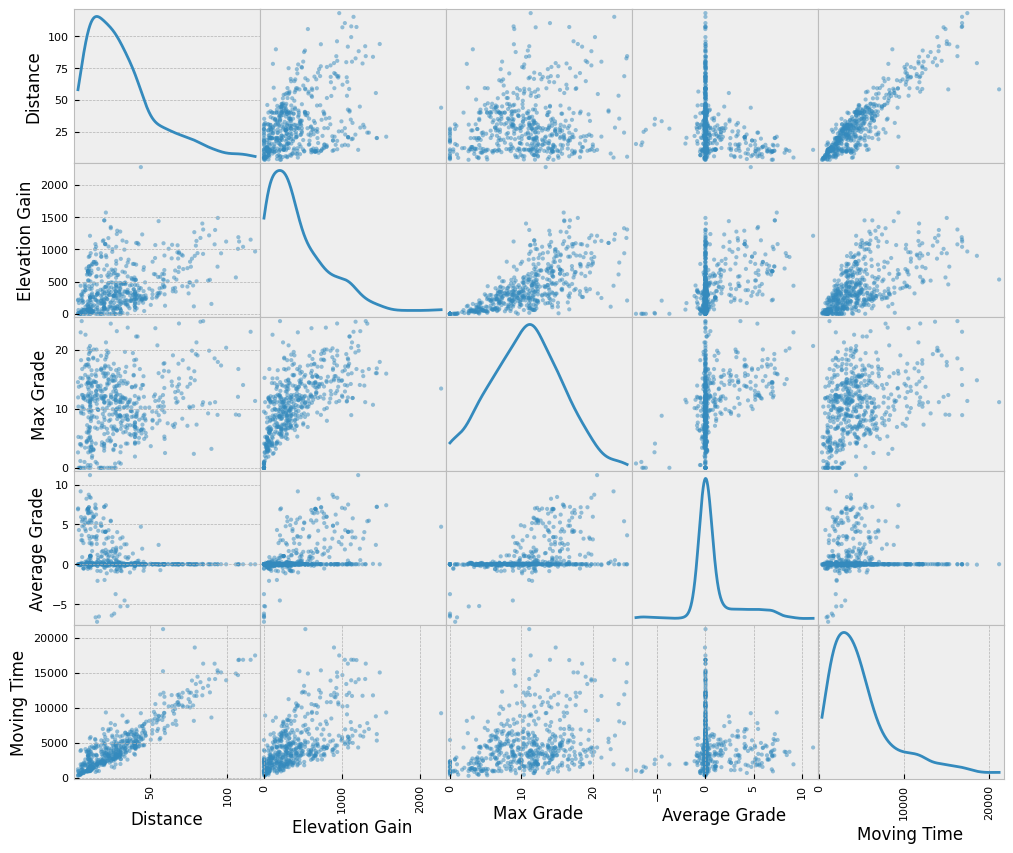

In [25]:
from pandas.plotting import scatter_matrix
scatter_matrix(activities, diagonal="kde", figsize=(12,10));

As expected we can see a linear relationship between the Moving Time and the Distance.

<AxesSubplot: xlabel='Distance', ylabel='Moving Time'>

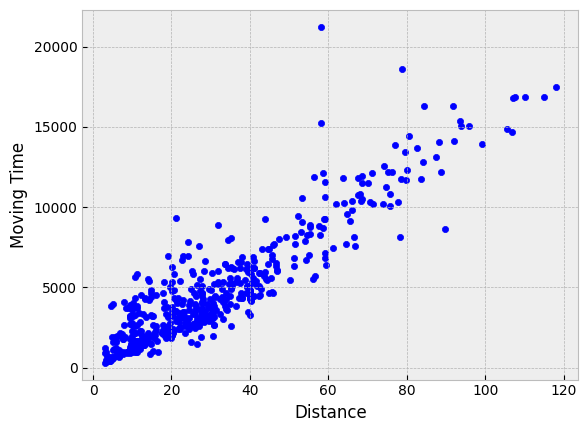

In [26]:
activities.plot(kind="scatter", x='Distance', y='Moving Time', grid=True)

there is an approximately linear relationship between Elevation Gain and the Distance: more Kms more the overall gain in altitude

<AxesSubplot: xlabel='Distance', ylabel='Elevation Gain'>

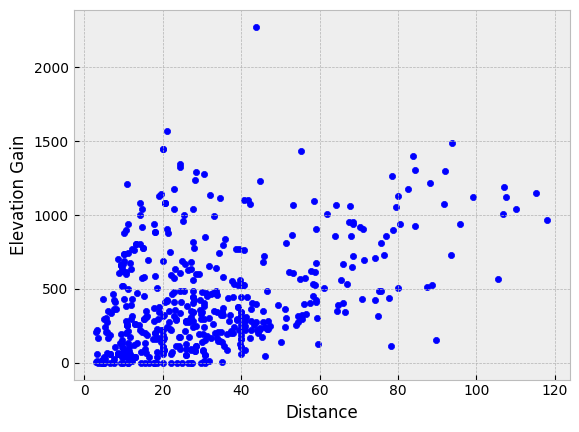

In [27]:
activities.plot(kind="scatter", x='Distance', y='Elevation Gain', grid=True)

We can also generate a 3D plot of the observations, which can sometimes help to interpret the data more easily. Here we plot 'Moving Time' as a function of 'Distance' and 'Elevation Gain'.

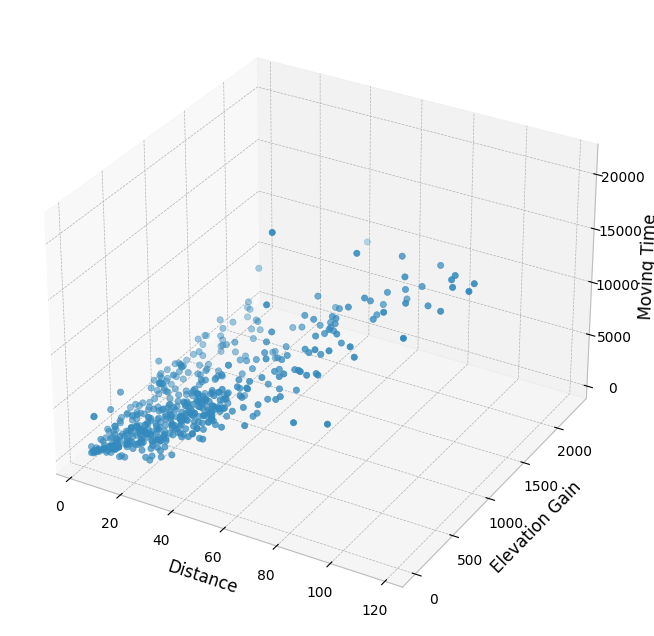

In [28]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(activities["Distance"], activities["Elevation Gain"], activities["Moving Time"])
ax.set_xlabel("Distance")
ax.set_ylabel("Elevation Gain")
ax.set_zlabel("Moving Time")
ax.set_facecolor("white")

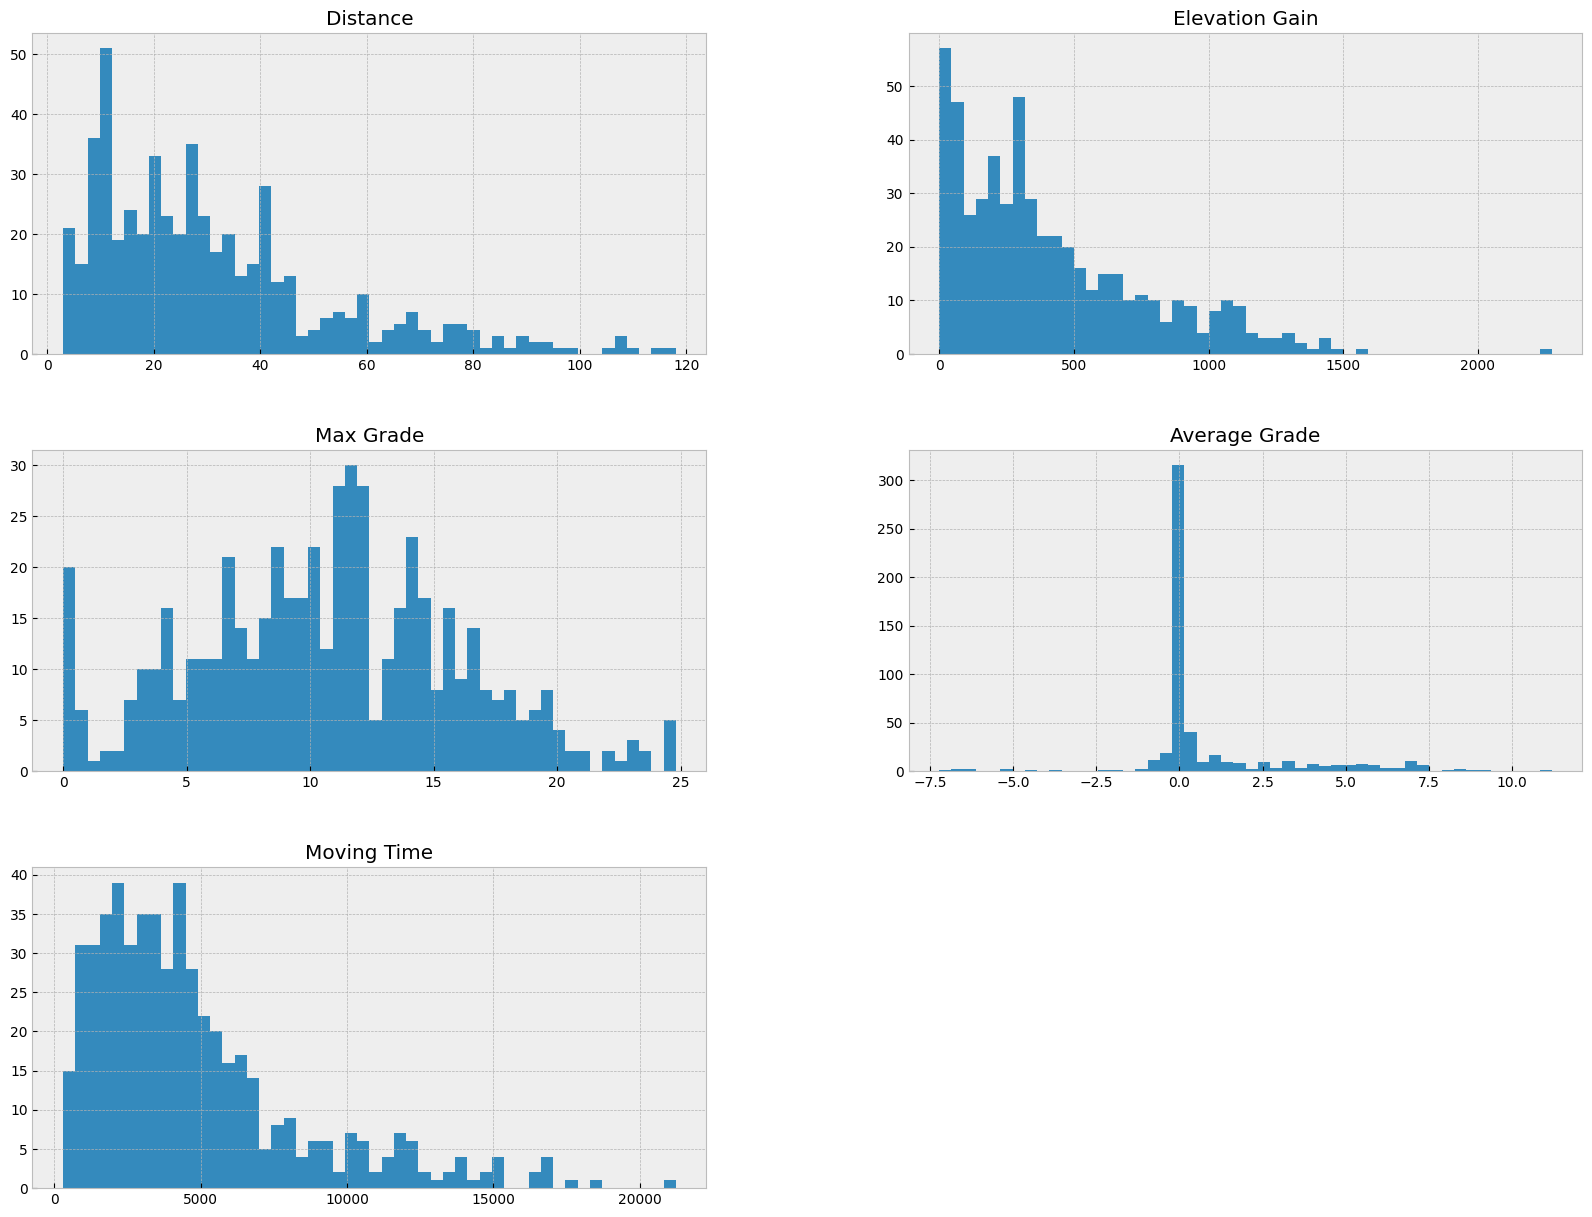

In [29]:
%matplotlib inline
activities.hist(bins=50, figsize=(20,15))
plt.show()

## Looking for correlation

You can easily compute the standard correlation coefficient (also called Pearson's r) between every pair of attributes using the 'corr()' method.

In [30]:
corr_matrix= activities.corr()

In [31]:
corr_matrix["Moving Time"].sort_values(ascending=False)

Moving Time       1.000000
Distance          0.909245
Elevation Gain    0.621053
Max Grade         0.357564
Average Grade    -0.065905
Name: Moving Time, dtype: float64

The Moving Time is strongly correlated to the 'Distance' and also to the 'Elevation Gain'. This is asbolutely expected.

## Avoiding sampling bias

Before splitting the dataset into a Training and a Test set we need to face the problem of 'Sampling bias'. Usually we can use a random samoling approach. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. In our case the dataset is quite small. The risk to face sampling bias is high. We need a workaround.

From the previous histograms we can notice that most 'Distance' values are clustered around 10 to 15 Km's, but some 'Distance's go far beyond 70. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the 
pd.cut() function to create an income category attribute with 5 categories (labeled
from 1 to 6): category 1 ranges from 0 to 20 (i.e., less than 20 Km's), category 2 from
20 to 40 Km's, and so on:

In [32]:
activities["Distance_cat"] = pd.cut(activities["Distance"],
 bins=[0, 20, 40, 60, np.inf],
 labels=[1, 2, 3, 4])

<AxesSubplot: >

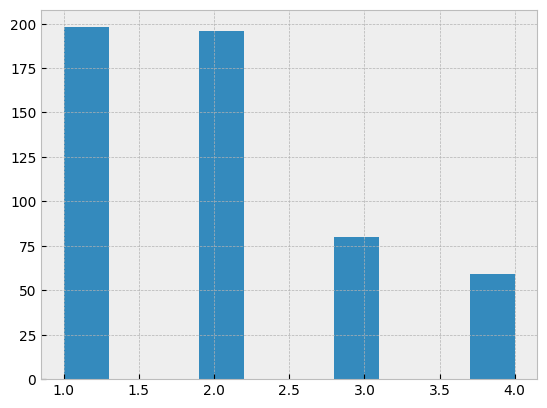

In [33]:
activities["Distance_cat"].hist()

Now you are ready to do stratified sampling based on the income category. For this
you can use Scikit-Learn’s StratifiedShuffleSplit class:

In [34]:
activities = activities.reset_index()

In [35]:
activities.pop('index')

0        0
1        2
2        5
3       12
4       13
      ... 
528    847
529    849
530    851
531    852
532    854
Name: index, Length: 533, dtype: int64

In [36]:
activities.head()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time,Distance_cat
0,59.08,412.800842,9.4,0.000169,10637.0,3
1,35.56,114.721718,11.1,-0.001125,5067.0,2
2,56.41,574.050659,11.9,-0.001950,11906.0,3
3,34.89,207.574387,10.6,0.001146,4466.0,2
4,9.82,41.745453,6.6,-0.360192,1978.0,1


In [37]:
activities.index

RangeIndex(start=0, stop=533, step=1)

## Splitting Training and Test sets

Now it's time to get our Training and Test sets.

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(activities, activities["Distance_cat"]):
    strat_train_set_n = activities.iloc[train_index]
    strat_test_set_n = activities.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [39]:
strat_train_set, strat_test_set = strat_splits[0]

In [40]:
strat_train_set.describe()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time
count,426.000000,426.000000,426.000000,426.000000,426.000000
mean,31.194437,427.087518,10.907744,0.960250,4834.488263
std,22.266853,357.343806,5.223845,2.224219,3569.244177
min,3.000000,0.000000,0.000000,-7.224899,308.000000
25%,13.300000,166.250000,7.167882,-0.007104,2313.750000
50%,26.435000,323.973526,11.079717,0.003662,3982.500000
75%,40.350000,621.500000,14.300000,0.675681,6044.250000
max,110.200000,2275.000000,24.799999,11.200340,21230.000000


In [41]:
strat_test_set.describe()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time
count,107.000000,107.000000,107.000000,107.000000,107.000000
mean,31.043458,367.496713,9.784863,0.428297,4523.859813
std,23.290602,351.910466,5.507412,2.389417,3689.425285
min,4.260000,0.000000,0.000000,-6.669187,441.000000
25%,12.740000,84.500000,6.538627,-0.015863,1974.000000
50%,25.960000,265.904999,9.882262,0.000242,3542.000000
75%,40.040000,521.036072,12.900000,0.177980,5868.500000
max,118.010000,1570.000000,24.700001,8.458021,17473.000000


It's much shorter to get a single stratified split:

In [42]:
strat_train_set, strat_test_set = train_test_split(
    activities, test_size=0.2, stratify=activities["Distance_cat"], random_state=42)

Let's extract the labels for the Training and Test sets

In [43]:
strat_train_set_labels=strat_train_set.pop("Moving Time")

In [44]:
strat_test_set_labels=strat_test_set.pop("Moving Time")

In [45]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 125 to 33
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Distance        426 non-null    float64 
 1   Elevation Gain  426 non-null    float64 
 2   Max Grade       426 non-null    float64 
 3   Average Grade   426 non-null    float64 
 4   Distance_cat    426 non-null    category
dtypes: category(1), float64(4)
memory usage: 17.3 KB


In [46]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 307 to 317
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Distance        107 non-null    float64 
 1   Elevation Gain  107 non-null    float64 
 2   Max Grade       107 non-null    float64 
 3   Average Grade   107 non-null    float64 
 4   Distance_cat    107 non-null    category
dtypes: category(1), float64(4)
memory usage: 4.5 KB


In [47]:
strat_test_set["Distance_cat"].value_counts() / len(strat_test_set)

1    0.373832
2    0.364486
3    0.149533
4    0.112150
Name: Distance_cat, dtype: float64

In [48]:
# extra code – computes the data for Figure 2–10

def distance_cat_proportions(data):
    return data["Distance_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(activities, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": distance_cat_proportions(activities),
    "Stratified %": distance_cat_proportions(strat_test_set),
    "Random %": distance_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Distance Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Distance Category,,,,,
1,37.15,37.38,35.51,0.63,-4.40
2,36.77,36.45,34.58,-0.88,-5.97
3,15.01,14.95,18.69,-0.37,24.53
4,11.07,11.21,11.21,1.31,1.31


In [49]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Distance_cat", axis=1, inplace=True)

## Linear Regression Model

We will created a fitted linear model using the formula API of the scikit-learn library.

In [50]:
linear_model = LinearRegression()
linear_model.fit(strat_train_set, strat_train_set_labels) 

LinearRegression()

### View Parameters 
The $\mathbf{w}$ and $\mathbf{b}$ parameters are referred to as 'coefficients' and 'intercept' in scikit-learn. In other term the model function can be written as $f_{w,b}(\vec{x})$

In [51]:
b = linear_model.intercept_
w = linear_model.coef_
print(f"w = {w:}, b = {b:0.2f}")

w = [137.39891478   1.61084102  49.47015541 123.63226763], b = -797.89


Let's give it a try by using some routes from the Test set.

In [52]:
some_data=strat_test_set.iloc[0:5,:]

In [53]:
some_labels=strat_test_set_labels.iloc[0:5]
some_labels.head()

307     984.0
233    6668.0
360    2184.0
476    2592.0
104    5234.0
Name: Moving Time, dtype: float64

In [54]:
print(type(some_data))
some_labels_predicted = linear_model.predict(some_data) # it return a numpy ndarray
some_labels_predicted

<class 'pandas.core.frame.DataFrame'>


array([ 737.74760884, 5675.08144265, 2439.22923342, 3312.93197032,
       4642.93902431])

In [55]:
error = some_labels_predicted - some_labels.to_numpy()

In [56]:
print("Error (mins):", error/60)

Error (mins): [ -4.10420652 -16.54864262   4.25382056  12.01553284  -9.85101626]


### Mean squared error

Let’s measure the regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error function.

In [57]:
from sklearn.metrics import mean_squared_error

In [58]:
lin_mse = mean_squared_error(some_labels, some_labels_predicted)
lin_rmse = np.sqrt(lin_mse)
print("rmse (min)= {}".format(lin_rmse/60))

rmse (min)= 10.490115575309789


## Calculate accuracy

You can calculate this accuracy of this model by calling the `score` function on the whole Training set.

In [59]:
print("Accuracy on training set:", linear_model.score(strat_train_set, strat_train_set_labels))

Accuracy on training set: 0.888520806805415


The model is doing poor on the Training set. It's too simple and it cannot match the training data at the best. Let's try another model.

In [60]:
print("Accuracy on test set:", linear_model.score(strat_test_set, strat_test_set_labels))

Accuracy on test set: 0.9269220757824642


## Challenge Gunsan-Saemangeum 2002 prediction

Let's try to predict the Moving Time of a new route I rode the last weew, the Challenge Gunsan-Saemangeum 2022.

The input data are:
- Distance: 30 Km's
- Elevation Gain: 26
- Max Grade: 3%
- Average Grade: 0%

The real Moving Time is 53 minutes

In [61]:
gunsan_real_moving_time=53

<center><img src="test-route.png" alt="Test Route - Challenge Gunsan-Saemangeum 2022" /></center>

In [62]:
gunsan_route_data = pd.DataFrame({"Distance": [29.99], "Elevation Gain": [26], "Max Grade": [3], "Average Grade": [0]})

In [63]:
predicted_moving_time = linear_model.predict(gunsan_route_data)/60

In [64]:
print("Predicted Moving Time (mins):{}, error : {}%".format(predicted_moving_time, abs(100*(predicted_moving_time-gunsan_real_moving_time)/gunsan_real_moving_time)))

Predicted Moving Time (mins):[58.54994314], error : [10.47159082]%


## Decision tree Model

In order to try to improve the Model accuracy let's a different model able to catch nonlinear patterns in the data.
Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data.

In [65]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(strat_train_set, strat_train_set_labels)

DecisionTreeRegressor()

In [66]:
strat_train_set_predictions = tree_reg.predict(strat_train_set)
tree_mse = mean_squared_error(strat_train_set_labels, strat_train_set_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [67]:
print("Accuracy on training set:", tree_reg.score(strat_train_set, strat_train_set_labels))

Accuracy on training set: 1.0


In [68]:
print("Accuracy on test set:", tree_reg.score(strat_test_set, strat_test_set_labels))

Accuracy on test set: 0.8820384137388997


Let's try to predict the 'Moving Time of the previous route.

In [69]:
predicted_moving_time = tree_reg.predict(gunsan_route_data)/60

In [70]:
print("Predicted Moving Time (mins):{}, error : {}%".format(predicted_moving_time, abs(100*(predicted_moving_time-gunsan_real_moving_time)/gunsan_real_moving_time)))

Predicted Moving Time (mins):[48.95], error : [7.64150943]%


Now the error is lower than the error of the Linear Model.

In [71]:
from sklearn.tree import export_graphviz

In [72]:
export_graphviz(
 tree_reg,
 out_file="routes_tree.dot",
 feature_names=["Distance", "Elevation Gain", "Max Grade", "Average Grade"],
 class_names="Moving Time",
 rounded=True,
 filled=True
)

In [73]:
! dot -Tpng routes_tree.dot -o routes_tree.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.964274 to fit


<center><img src="routes_tree.png" alt="Decision Tree for the 'Moving Time' regresso" /></center>

The RMSE of the Decision Tree model is '0'. No errors. This is confirmed by the Accuracy calculation on the Training Set which is '1'.

The Accuracy on the Test set is bit lower, but high enough.

## Nusfjord to Haukland Beach | Norway prediction

Let's try to predict the Moving Time of a new route I rode recently, the Nusfjord to Haukland Beach in Norway.

The input data are:

- Distance: 28.62 Km's
- Elevation Gain: 303
- Max Grade: 9%
- Average Grade: 1%

The real Moving Time is 54 minutes

In [74]:
nusfjord_real_moving_time=53

In [75]:
nusfjord_route_data = pd.DataFrame({"Distance": [28.62], "Elevation Gain": [303], "Max Grade": [9], "Average Grade": [1]})

In [76]:
predicted_moving_time = tree_reg.predict(nusfjord_route_data)/60

In [77]:
print("Predicted Moving Time (mins):{}, error : {}%".format(predicted_moving_time, abs(100*(predicted_moving_time-nusfjord_real_moving_time)/nusfjord_real_moving_time)))

Predicted Moving Time (mins):[54.43333333], error : [2.70440252]%


The Moving Time has been predicted with a really small error.

## Evaluation function

Here below a couple of functions helpful to execute the prediction and the evaluation in a more flexible way.

In [78]:
def prediction(model, moving_time, route_data):
    predicted_moving_time = model.predict(route_data)/60
    error = abs(100*(predicted_moving_time-moving_time)/moving_time)
    return predicted_moving_time, error

def evaluation(model, train_set, train_set_labels, test_set, test_set_labels):
    train_set_predictions = model.predict(train_set)
    mse = mean_squared_error(train_set_labels, train_set_predictions)
    rmse = np.sqrt(tree_mse)
    train_set_acc = model.score(train_set, train_set_labels)
    test_set_acc = model.score(test_set, test_set_labels)
    
    return rmse, train_set_acc, test_set_acc

In [79]:
moving_time, error = prediction(tree_reg, nusfjord_real_moving_time, nusfjord_route_data)

In [80]:
print("Nusfjord Moving time: {}, error % {}".format(moving_time, error))

Nusfjord Moving time: [54.43333333], error % [2.70440252]


In [81]:
moving_time, error = prediction(tree_reg, gunsan_real_moving_time, gunsan_route_data)

In [82]:
print("Gunsan Moving time: {}, error % {}".format(moving_time, error))

Gunsan Moving time: [48.95], error % [7.64150943]


In [83]:
rmse, train_acc, test_acc = evaluation(tree_reg, strat_train_set, strat_train_set_labels, strat_test_set, strat_test_set_labels)

In [84]:
print("Decision Tree RMSE: {}, Accuracy on the Training set: {}, Accuracy on the Test set: {}".format(rmse, train_acc, test_acc))

Decision Tree RMSE: 0.0, Accuracy on the Training set: 1.0, Accuracy on the Test set: 0.8820384137388997


## Conclusions

The purpose of this exercise was to to develop a Machine Learning Model to predict the 'Moving Time' of a Route based. 
- Data includes more of 500 'outdoor' and 'indoor' routes. 
- The 'indoor' routes have been exported by Rouvy to Strava.
- The 'outdoor' routes have been recorded directly by Strava
- The data have been cleaned and prepared for training.
- A couple of Regressors have been trained on the prepared data
- A Linear Regressor prooved to be good, but unable to perfectly fit the training dataset. The accuracy on the training was comparable with the test set one. There was room for some improvement. Maybe the linear model didn't fit at the best.
- The Decision Tree showed a better result to predict the Moving time of an 'unseen' new route. The Decision Tree model has been able to predict the Moving Time of a new route (not seen at all during the training, with an error of less than 1 minute (0.8%) on a route of 53 minutes as effective 'Moving Time'.